## 0. Importing packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib
import matplotlib.pyplot as plt
import pymc3 as pm
# import theano
import theano.tensor as tt

## 1. Preparation of Dataset

In [3]:
data = pd.read_csv("../Cleaning_Engineering/base_cleaned.csv")
data.shape

(637976, 20)

In [5]:
# Check the shape of result data 
# It's the point I should change
big_data = pd.read_csv("../Cleaning_Engineering/added_demand_estimates_eta_variation.csv")
# /Users/jacob/Documents/GitHub/Dynamic_Project/Cleaning_Engineering/added_demand_estimates_eta_variation.csv
big_data.shape

(6594711, 15)

In [3]:
# Use only the data from the first 90%
train_data = data.iloc[:int(data.shape[0]*.9)]
# Drop one of the columns that is highly correlated with another
train_data = train_data.drop(columns=["Unnamed: 0"], axis=1)
# Select features to use
train_data_filtered = train_data[["time_stamp_x", "cab_type", "source", "destination", "car_type", "weekday", "rush_hour", "is_raining", "temp_groups", "surge_multiplier", "price"]]
train_data_filtered.head()
print(train_data_filtered.shape)

(574178, 11)


In [4]:

# Calculate the base_price, quartiles, and means for each source-destination-cartye combination from the original data
base_price_series = train_data_filtered.groupby(['source', 'destination', 'car_type'])['price'].min()
first_quartile_series = train_data_filtered.groupby(['source', 'destination', 'car_type'])['price'].quantile(0.25)
mean_price_series = train_data_filtered.groupby(['source', 'destination', 'car_type'])['price'].mean()
third_quartile_series = train_data_filtered.groupby(['source', 'destination', 'car_type'])['price'].quantile(0.75)
max_price_series = train_data_filtered.groupby(['source', 'destination', 'car_type'])['price'].max()

# Merge the base prices back into the original DataFrame
data = train_data_filtered.merge(base_price_series.rename('base_price'), on=['source', 'destination', 'car_type'])
#data = data.merge(first_quartile_series.rename('first_quartile_price'), on=['source', 'destination', 'car_type'])
#data = data.merge(mean_price_series.rename('mean_price'), on=['source', 'destination', 'car_type'])
#data = data.merge(third_quartile_series.rename('third_quartile_price'), on=['source', 'destination', 'car_type'])
#data = data.merge(max_price_series.rename('max_price'), on=['source', 'destination', 'car_type'])

In [5]:
data.head()

,time_stamp_x,cab_type,source,destination,car_type,weekday,rush_hour,is_raining,temp_groups,surge_multiplier,price,base_price
0,1543203646318,Lyft,Boston University,Theatre District,Luxury SUV,1,0,0,40,1.0,34.0,27.0
1,1543209185329,Lyft,Boston University,Theatre District,Luxury SUV,1,0,0,40,1.0,38.5,27.0
2,1543210587621,Lyft,Boston University,Theatre District,Luxury SUV,1,0,0,40,1.0,32.5,27.0
3,1543213442411,Lyft,Boston University,Theatre District,Luxury SUV,1,0,0,40,1.0,34.0,27.0
4,1543213502686,Uber,Boston University,Theatre District,Luxury SUV,1,0,0,40,1.0,33.0,27.0


In [6]:
# Data breakdown for each combination min, quartiles and max
base_price_df = base_price_series.reset_index(name='base_price')
distribution_df = base_price_df.merge(first_quartile_series.rename("first_quartile"), on=['source', 'destination', 'car_type'])
distribution_df = distribution_df.merge(mean_price_series.rename("mean_price"), on=['source', 'destination', 'car_type'])
distribution_df = distribution_df.merge(third_quartile_series.rename("third_quartile"), on=['source', 'destination', 'car_type'])
distribution_df = distribution_df.merge(max_price_series.rename("max_price"), on=['source', 'destination', 'car_type'])

In [7]:
car_types = list(set(distribution_df.car_type))

## 2. Visualization of Price Distribution by Service Type

Each visual shows how each car type how the distribution differs per location. For example base price from Fenway might be different than another location which creates the distribution. Chart to chart comparison you can see the difference between car type prices.

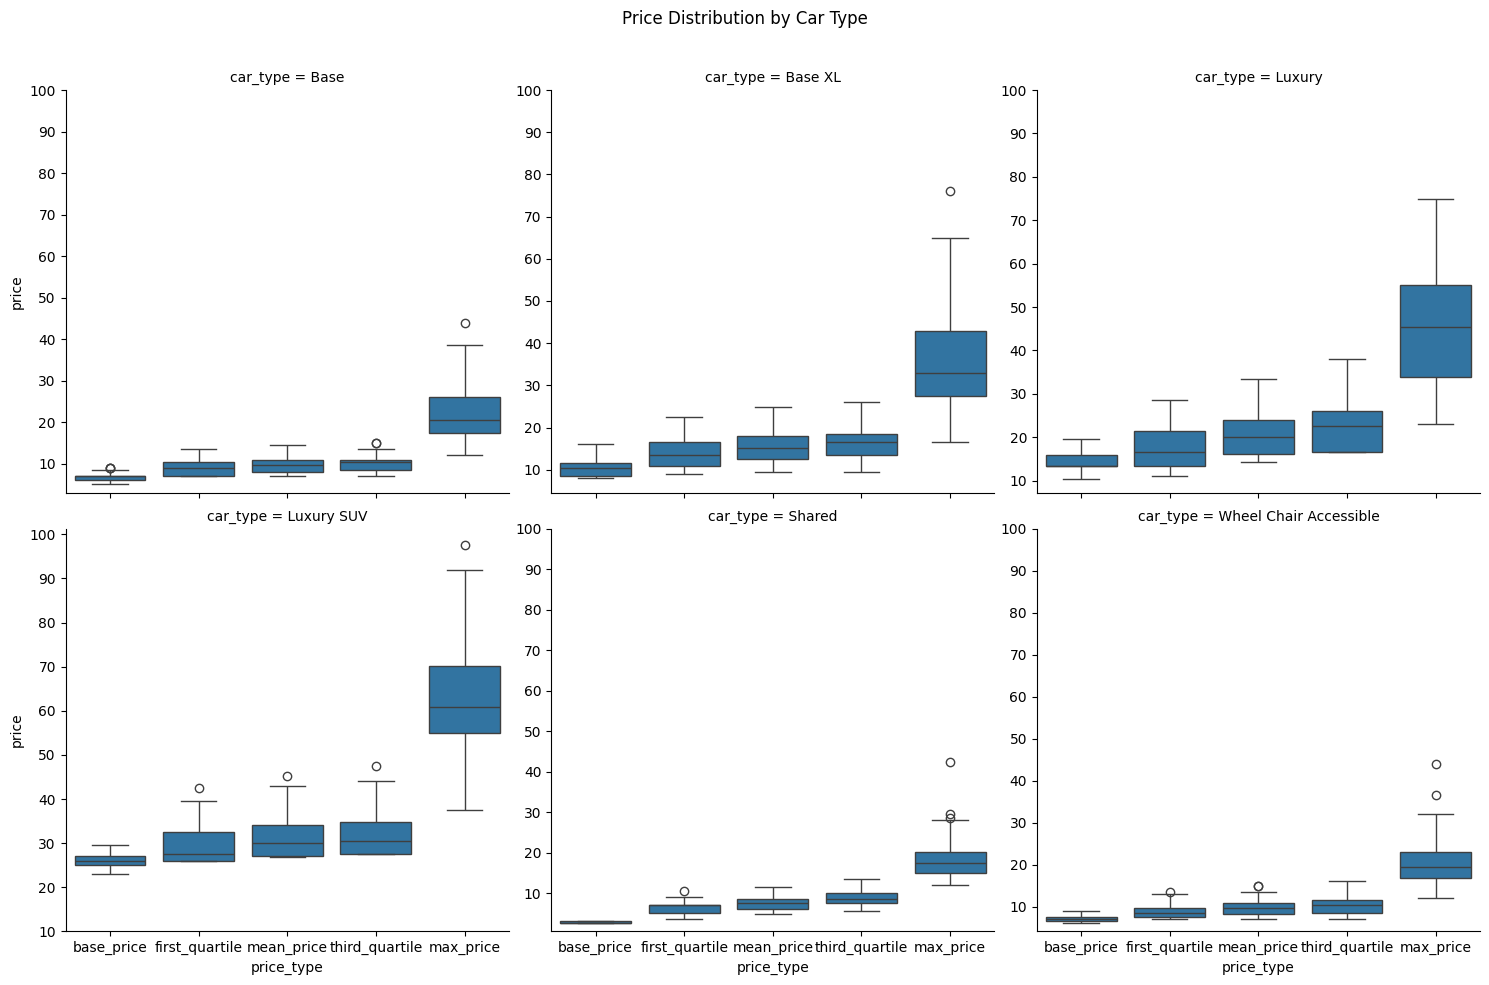

In [8]:
# You want to plot 'base_price', 'first_quartile', 'mean_price', 'third_quartile', 'max_price'.

# You may need to reformat your data to have 'price_type' and 'price' columns.
df_melted = distribution_df.melt(id_vars=['source', 'destination', 'car_type'],
                                 value_vars=['base_price', 'first_quartile', 'mean_price', 'third_quartile', 'max_price'],
                                 var_name='price_type', value_name='price')
# Set the order of the categories
price_type_order = ['base_price', 'first_quartile', 'mean_price', 'third_quartile', 'max_price']

# Create a FacetGrid object with a boxplot for each 'car_type'
g = sns.FacetGrid(df_melted, col='car_type', col_wrap=3, sharex=True, sharey=False, height=5)

# Map the boxplot with the order of price types
g.map(sns.boxplot, 'price_type', 'price', order=price_type_order)


# Define the x-axis limits and ticks
y_ticks = list(range(10, 101, 10))
g.set(yticks=y_ticks)  # Set the same x-ticks for all the axes

# Adding some additional customizations
g.fig.subplots_adjust(top=0.9)  # Adjust the Figure in 'g'
g.fig.suptitle('Price Distribution by Car Type')

plt.show()


## 3. Demand Estimation

### 3.1. Calculating demand elasticity and variables(a, b) with Baysian Method (MCMC)

The provided code block defines a function estimate_demand_parameters that uses Bayesian statistical modeling with PyMC3 to estimate demand elasticity parameters from a given pandas DataFrame. Specifically, it sets up a probabilistic model to understand how the demand for a product or service is influenced by its price, incorporating factors like price elasticity (eta), and constants a and b that define the demand curve. It employs priors, a demand function based on the exponential decay of price, and observes this against actual price data. After sampling from the posterior distribution to infer these parameters, it adds the estimated values as new columns (estimated_eta, estimated_a, estimated_b) to the original DataFrame. This approach provides a statistical framework to understand and quantify the relationship between price and demand in the given dataset.

In the code block, the demand function is defined as demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b. In this function, a, b, and eta are parameters that play distinct roles in modeling the relationship between price and demand:

- eta (Price Elasticity of Demand): This parameter represents the price elasticity of demand, a key concept in economics that describes how the quantity demanded of a good or service is affected by its price. In the model, eta is used within an exponential function to capture the sensitivity of demand to changes in price. A higher absolute value of eta indicates greater sensitivity.
- a (Demand Scaling Factor): The parameter a acts as a scaling factor for the demand. It adjusts the overall level of demand independently of the price. This factor can be influenced by variables other than price, such as product quality, consumer preferences, or market conditions.
- b (Baseline Demand): The parameter b represents a baseline or intercept term in the demand function. It signifies the level of demand when the effect of price is not considered (e.g., when price impact is zero or negligible). Essentially, it's a constant term that indicates the demand level due to factors other than price.  
  
Together, these parameters (eta, a, and b) in the demand function provide a comprehensive view of how demand varies with price, accounting for both the direct impact of price changes (through eta) and other factors influencing demand levels (a and b). By estimating these parameters using Bayesian methods in PyMC3, the function aims to create a nuanced and probabilistic understanding of demand dynamics in the given dataset.

In [10]:
data = pd.read_csv("../Cleaning_Engineering/base_cleaned.csv")
data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
data = data.set_index('time_stamp_x')
data = data.sort_index()
data.head()

,distance,cab_type,source,destination,name,car_type,weekday,rush_hour,temp,clouds,pressure,rain,humidity,wind,is_raining,temp_groups,surge_multiplier,price
time_stamp_x,,,,,,,,,,,,,,,,,,
1543203646318,3.03,Lyft,Boston University,Theatre District,Lux Black XL,Luxury SUV,1,0,41.07,0.86,1014.39,NaN,0.92,1.36,0,40,1.0,34.0
1543203646319,1.30,Uber,South Station,Theatre District,Black,Luxury,1,0,40.86,0.87,1014.39,NaN,0.93,1.60,0,40,1.0,18.5
1543203646320,2.43,Lyft,Northeastern University,Beacon Hill,Lyft,Base,1,0,40.81,0.89,1014.35,NaN,0.93,1.36,0,40,1.0,10.5
1543203646320,2.71,Uber,Theatre District,Fenway,UberXL,Base XL,1,0,40.80,0.87,1014.39,NaN,0.93,1.55,0,40,1.0,32.0
1543203646320,2.71,Uber,Theatre District,Fenway,UberX,Base,1,0,40.80,0.87,1014.39,NaN,0.93,1.55,0,40,1.0,19.5


## Demand Parameters Estimation Experiment

### Overview

The `estimate_demand_parameters` function is designed to estimate demand parameters (eta, a, b) in a given dataset. This function uses Bayesian statistical modeling, specifically with the PyMC3 library, to infer these parameters based on observed price data and other relevant variables.

### Function Description

- **estimate_demand_parameters(dataframe, price_col)**:
  - **Purpose**: Estimates demand parameters eta, a, and b.
  - **Parameters**:
    - `dataframe`: A Pandas DataFrame containing the dataset.
    - `price_col`: The name of the column in the DataFrame that contains price data.

### Process

1. **Define Priors**:
   - The function begins by defining priors for the parameters using a Gamma distribution for eta and Uniform distributions for a and b.

2. **Model Specification**:
   - The price data is converted into a Theano tensor, which is a requirement for PyMC3 models.
   - The demand function is defined as `a * exp(-abs(eta) * log(price_data)) + b`.

3. **Observation and Sampling**:
   - Gaussian noise is assumed in the observed data.
   - The function then samples from the posterior distribution to estimate the parameters.

4. **Posterior Analysis**:
   - After sampling, the mean values of the posterior distributions for eta, a, and b are extracted.

5. **Dataframe Update**:
   - The function adds new columns to the original dataframe with estimated values for eta, a, and b.

### Output

- The function returns the updated DataFrame with the estimated parameters and the trace from the PyMC3 model.
- This methodology allows for a probabilistic understanding of demand as a function of price and can be particularly useful in dynamic pricing models.

### Dependencies

- PyMC3: A Python library for probabilistic programming.
- Theano: A Python library that allows you to define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays.

### Usage

To use this function, ensure that your dataset contains at least the price column and other relevant features that may affect demand. The function will then provide estimates for the demand parameters, enhancing your analysis and modeling capabilities in pricing strategies.


In [11]:

def estimate_demand_parameters(dataframe, price_col):
    """
    Estimates the demand parameters (eta, a, b) using PyMC3 and adds them as new columns in the dataframe.

    :param dataframe: Pandas DataFrame containing the data
    :param price_col: Name of the column containing price data
    :return: DataFrame with new columns for eta, a, b estimates
    """
    with pm.Model() as model:
        # Define priors
        eta_shape = 2 
        eta_rate = 5  
        eta = pm.Gamma('eta', alpha=eta_shape, beta=eta_rate) + 0.25
        a = pm.Uniform('a', lower=0, upper=100)
        b = pm.Uniform('b', lower=0, upper=20)

        # Convert the price data to a theano tensor
        price_data = tt.as_tensor_variable(dataframe[price_col].values)

        surge_multiplier_data = tt.as_tensor_variable(dataframe['surge_multiplier'].values)
        # Define the demand function using pm.math.exp for exponentiation
        demand = a * pm.math.exp(-tt.abs_(eta) * tt.log(price_data)) + b

        # Assuming Gaussian noise in the observed data
        observed = pm.Normal('observed', mu=demand, sd=1, observed=dataframe[price_col])

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, return_inferencedata=False)

    # Extracting the mean of the posterior distributions
    eta_mean = np.mean(trace['eta'])
    a_mean = np.mean(trace['a'])
    b_mean = np.mean(trace['b'])

    # Adding new columns to the dataframe
    dataframe['estimated_eta'] = eta_mean
    dataframe['estimated_a'] = a_mean
    dataframe['estimated_b'] = b_mean

    return dataframe, trace

### !!! Warning: It will take around an hour to finish to generate estimated eta, a and b
### !!! Please use the ready-made csv file to analyze (/Cleaning_Engineering/added_demand_estimates.csv)

In [13]:
# Generate a list of all unique combinations of car_type, source, destination
lst_car_type = list(set(data.car_type))
lst_source = list(set(data.source))
lst_destination = list(set(data.destination))

results_list = []

# Iterate over all combinations
for car_type in lst_car_type:
    for source in lst_source:
        for destination in lst_destination:
            # Filter the data for the current combination
            filtered_data = data[(data['car_type'] == car_type) & (data['source'] == source) & (data['destination'] == destination)]

            # Treat the combination as valid only if data points exist
            if not filtered_data.empty:
                try:
                    result_df, _ = estimate_demand_parameters(filtered_data, 'price')
                    results_list.append(result_df)
                except Exception as e:
                    print(f"Error processing combination: CarType={car_type}, Source={source}, Destination={destination}")
                    print(f"Error message: {e}")

# Combine the results into a single DataFrame
combined_df = pd.concat(results_list, ignore_index=True)

# Calculate the estimated demand for each combination
combined_df['estimated_demand'] = combined_df['estimated_a'] * np.exp(-np.abs(combined_df['estimated_eta']) * np.log(combined_df['price'])) + combined_df['estimated_b']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, eta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8789567568046639, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.693202242132478, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6585574564888986, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.8791377625141813, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.8914298117264458, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7040893003345481, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8888326362733993, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: Setti

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6933150926260303, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6995559077118234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6534628228192875, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6016477589866717, but should be close to 0.8. Try to increase the number of tuning steps.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704860419509687, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6685662280340823, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6831460404167753, but should be close to 0.8. Try to increase the number of tuning steps.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6425479980765062, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7016362639432481, but should be close to 0.8. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7117228709967559, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/33

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8797200211491406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7213802528718201, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8823698263880403, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8795894733054609, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7138147281527732, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6414072778665095, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6756184437134443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164248251560175, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6997041834087395, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173771765475203, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7167211765365273, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7049042967773745, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.70056283303103, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8805500776099363, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6493363543775362, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6989477718102567, but should be close to 0.8. Try to increase the number of tuning steps.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37393415400297797, but should be close to 0.8. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7118897566451516, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A va

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7062330759079442, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7058907081035557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7162475551744637, but should be close to 0.8. Try to increase the number of tuning steps.
There were 278 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43760361277736587, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_5961

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6971525207808298, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7108872950282544, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8795011880192002, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:3

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8805950464566993, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6840064644173306, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71641923296203, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7148181122590201, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961629710947388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7201808913518498, but should be close to 0.8. Try to increase the number of tuning steps.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7126746553716719, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mea

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6902703852848087, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7123610573653953, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 157 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6342802676165952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7082691147108128, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5998016105789938, but should be close to 0.8. Try to increase the number of tuning steps.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7158380959379398, but should be close to 0.8. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.886355465407428, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.p

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7103676627802963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8923837683324934, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: Setti

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/33

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7183190320999582, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_m

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.653806913349511, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.8800529191832616, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7047981642660504, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7084296792215243, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6965065798349098, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7066882447281284, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061160822794015, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:39

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6473503816398454, but should be close to 0.8. Try to increase the number of tuning steps.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_me

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7085852012431761, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6926604933636774, but should be close to 0.8. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_a'] = a_mean

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['estimated_eta'] = eta_mean
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6446406380094439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/ym/g7y_9d4j7q9d413s_kdqly_m0000gn/T/ipykernel_59617/338695646.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [15]:
combined_df.shape

(637976, 22)

In [16]:
combined_df.head()

,distance,cab_type,source,destination,name,car_type,weekday,rush_hour,temp,clouds,...,humidity,wind,is_raining,temp_groups,surge_multiplier,price,estimated_eta,estimated_a,estimated_b,estimated_demand
0,3.01,Uber,North Station,Boston University,Black SUV,Luxury SUV,1,0,40.51,1.00,...,0.92,1.35,0,40,1.0,35.0,0.000301,34.518257,19.99128,54.472641
1,3.01,Uber,North Station,Boston University,Black SUV,Luxury SUV,1,0,40.51,1.00,...,0.92,1.35,0,40,1.0,32.5,0.000301,34.518257,19.99128,54.473410
2,3.01,Uber,North Station,Boston University,Black SUV,Luxury SUV,1,0,40.54,1.00,...,0.92,1.42,0,40,1.0,35.0,0.000301,34.518257,19.99128,54.472641
3,3.15,Lyft,North Station,Boston University,Lux Black XL,Luxury SUV,1,1,41.10,0.97,...,0.92,1.82,0,40,1.0,34.0,0.000301,34.518257,19.99128,54.472942
4,3.09,Lyft,North Station,Boston University,Lux Black XL,Luxury SUV,1,1,41.10,0.97,...,0.92,1.82,0,40,1.0,32.5,0.000301,34.518257,19.99128,54.473410


In [ ]:
# Add a new column for the estimated demand
combined_df['estimated_demand'] = combined_df['estimated_a'] * np.exp(-np.abs(combined_df['estimated_eta']) * np.log(combined_df['price'])) + combined_df['estimated_b']
combined_df.head()

In [17]:
# Export to CSV
combined_df.to_csv("../Cleaning_Engineering/added_demand_estimates_eta_variation_ver2.csv", index=False)

In [18]:
combined_df.shape

(637976, 22)

In [20]:
combined_df.isna().sum()

distance                 0
cab_type                 0
source                   0
destination              0
name                     0
car_type                 0
weekday                  0
rush_hour                0
temp                     0
clouds                   0
pressure                 0
rain                544429
humidity                 0
wind                     0
is_raining               0
temp_groups              0
surge_multiplier         0
price                    0
estimated_eta            0
estimated_a              0
estimated_b              0
estimated_demand         0
dtype: int64

Note that the file is large, so we installed git LFS and committed the file.
The CSV file was about 100 megabytes, but the generated list was almost 650 megabytes, so when I made it into a PKL file, I split it into 90 megabytes and saved it.

In [41]:
import pickle
import os
import math

def load_large_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def save_split_pickle(data, base_filename, max_size_mb=90):
    # Calculate the number of parts to split the data into
    total_size_bytes = len(pickle.dumps(data))
    total_size_mb = total_size_bytes / (1024 * 1024)
    num_parts = math.ceil(total_size_mb / max_size_mb)

    # Store the data in multiple files
    part_length = len(data) // num_parts
    for i in range(num_parts):
        part_data = data[i * part_length: (i + 1) * part_length]
        with open(f'{base_filename}_part{i}.pkl', 'wb') as file:
            pickle.dump(part_data, file)

    # Store the remaining data
    if len(data) % num_parts != 0:
        part_data = data[num_parts * part_length:]
        with open(f'{base_filename}_part0{num_parts}.pkl', 'wb') as file:
            pickle.dump(part_data, file)


save_split_pickle(results_list, "../Cleaning_Engineering/result_list", max_size_mb=90)


It is highly recommended to use generated csv file(added_demand_estimates.csv) instead of running the above codes again.